In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame

from dataset.synthetic import SyntheticBanditDatasetWithCluster
from policy.policylearners import TruePolicyLearner
from policy.nn_model import MultiLayerPerceptron as MLP

from utils.common import visualize_learning_curve

In [2]:
# setting
n_users=50
dim_context=5
n_actions=100
n_cat_per_dim=10
n_cat_dim=5
n_clusters=20
beta=0.5
beta_user=1.0
reward_noise=1.0
random_state=12345
n_sim=30
hidden_layer_size=(30, 30, 30)
max_iter=51

In [3]:
def calc_policy_value(p_u, pi, q_x_a):
    return (p_u[:, None] * pi * q_x_a).sum()

def calc_var_all(p_u, pi, q_x_a, squared_q_x_a):
    squared_policy_value = (p_u[:, None] * pi * squared_q_x_a).sum()
    policy_value = (p_u[:, None] * pi * q_x_a).sum()
    var_all = squared_policy_value - (policy_value ** 2)
    return var_all

def calc_var_u(p_u, pi, q_x_a):
    q_u = (pi * q_x_a).sum(1)
    policy_value = (p_u * q_u).sum()
    var_u = (p_u * (q_u ** 2)).sum() - (policy_value ** 2)
    return var_u

In [4]:
dataset = SyntheticBanditDatasetWithCluster(
    n_users=n_users,
    dim_context=dim_context,
    n_actions=n_actions,
    n_cat_per_dim=n_cat_per_dim,
    n_cat_dim=n_cat_dim,
    n_clusters=n_clusters,
    beta=beta,
    beta_user=beta_user,
    reward_noise=reward_noise,
    random_state=random_state
)
true_dist_dict = dataset.true_dist_dict
q_x_a = true_dist_dict["q_x_a"]
p_u = true_dist_dict["p_u"]
x_u = true_dist_dict["x_u"]
squared_q_x_a = true_dist_dict["squared_q_x_a"]
pi_b = true_dist_dict["pi_0_a_x"]

pi_b_value = calc_policy_value(p_u, pi_b, q_x_a)
pi_b_new1_value = calc_var_all(p_u, pi_b, q_x_a, squared_q_x_a)
pi_b_new2_value = calc_var_u(p_u, pi_b, q_x_a)

value_df, new1_value_df, new2_value_df = DataFrame(), DataFrame(), DataFrame()
for s in tqdm(range(n_sim)):
    
    # Generalization
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="decision-making", hidden_layer_size=hidden_layer_size, random_state=s)
    generalization = TruePolicyLearner(
        nn_model=nn_model,
        ope_estimator=None,
        max_iter=max_iter,
        learning_rate_init=0.05,
    )
    generalization.fit(p_u=p_u, x_u=x_u, q_x_a=q_x_a, squared_q_x_a=squared_q_x_a)
    
    gen_value_ = DataFrame([generalization.test_value, ["Generalization"] * max_iter], index=["value", "method"]).T.reset_index()
    gen_new1_value_ = DataFrame([generalization.new1_value, ["Generalization"] * max_iter], index=["value", "method"]).T.reset_index()
    gen_new2_value_ = DataFrame([generalization.new2_value, ["Generalization"] * max_iter], index=["value", "method"]).T.reset_index()
    
    
    #  - \mathbb{V}_{x,a,r \sim \pi_{\theta}}[r] regularization
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="decision-making", hidden_layer_size=hidden_layer_size, random_state=s)
    new1 = TruePolicyLearner(
        nn_model=nn_model,
        ope_estimator=None,
        max_iter=max_iter,
        learning_rate_init=0.05,
        regularization_type="all_variance",
    )
    new1.fit(p_u=p_u, x_u=x_u, q_x_a=q_x_a, squared_q_x_a=squared_q_x_a)
    
    new1_value_ = DataFrame([new1.test_value, ["New1"] * max_iter], index=["value", "method"]).T.reset_index()
    new1_new1_value_ = DataFrame([new1.new1_value, ["New1"] * max_iter], index=["value", "method"]).T.reset_index()
    new1_new2_value_ = DataFrame([new1.new2_value, ["New1"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # - \mathbb{V}_{x}[\mathbb{E}_{a,r \sim \pi_{\theta}}[r]] regularization
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="decision-making", hidden_layer_size=hidden_layer_size, random_state=s)
    new2 = TruePolicyLearner(
        nn_model=nn_model,
        ope_estimator=None,
        max_iter=max_iter,
        learning_rate_init=0.05,
        regularization_type="x_variance"
    )
    new2.fit(p_u=p_u, x_u=x_u, q_x_a=q_x_a, squared_q_x_a=squared_q_x_a)

    new2_value_ = DataFrame([new2.test_value, ["New2"] * max_iter], index=["value", "method"]).T.reset_index()
    new2_new1_value_ = DataFrame([new2.new1_value, ["New2"] * max_iter], index=["value", "method"]).T.reset_index()
    new2_new2_value_ = DataFrame([new2.new2_value, ["New2"] * max_iter], index=["value", "method"]).T.reset_index()
    
    
    value_df = pd.concat([value_df, pd.concat([gen_value_, new1_value_, new2_value_])])
    new1_value_df = pd.concat([new1_value_df, pd.concat([gen_new1_value_, new1_new1_value_, new2_new1_value_])])
    new2_value_df = pd.concat([new2_value_df, pd.concat([gen_new2_value_, new1_new2_value_, new2_new2_value_])])
    
value_df.reset_index(inplace=True) 
value_df["pi_b_value"] = pi_b_value
value_df["rel_value"] = value_df["value"] / pi_b_value

new1_value_df.reset_index(inplace=True) 
new1_value_df["pi_b_value"] = pi_b_new1_value
new1_value_df["rel_value"] = new1_value_df["value"] / pi_b_new1_value

new2_value_df.reset_index(inplace=True) 
new2_value_df["pi_b_value"] = pi_b_new2_value
new2_value_df["rel_value"] = new2_value_df["value"] / pi_b_new2_value

100% 30/30 [00:20<00:00,  1.44it/s]


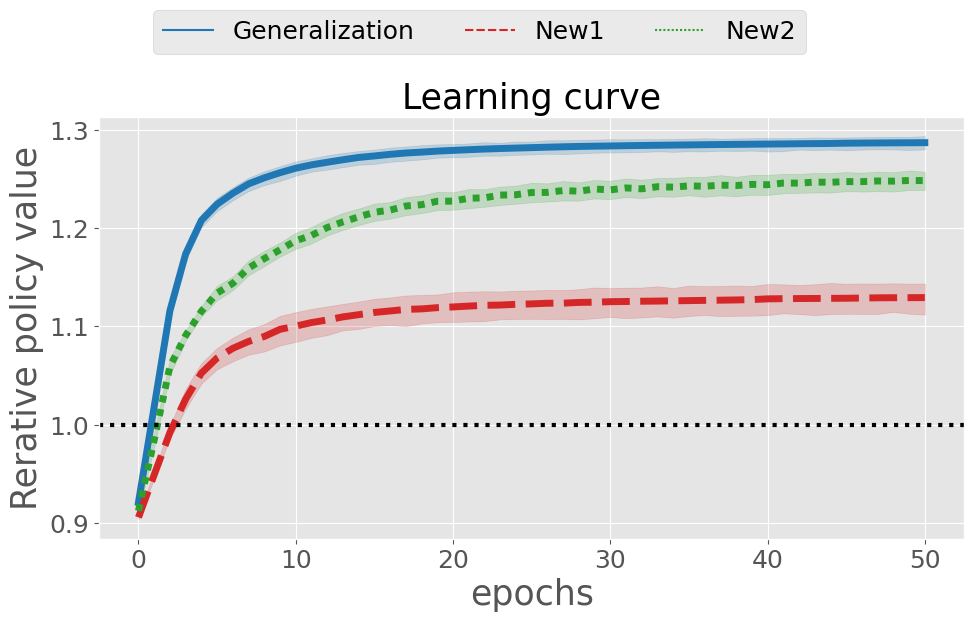

In [5]:
# curve of policy value i.e., \mathbb{E}_{x,a,r \sim \pi_{\theta}}[r]
# New2 achieved the best performance while New2 was worst performance due to the variance regularization.
visualize_learning_curve(value_df)

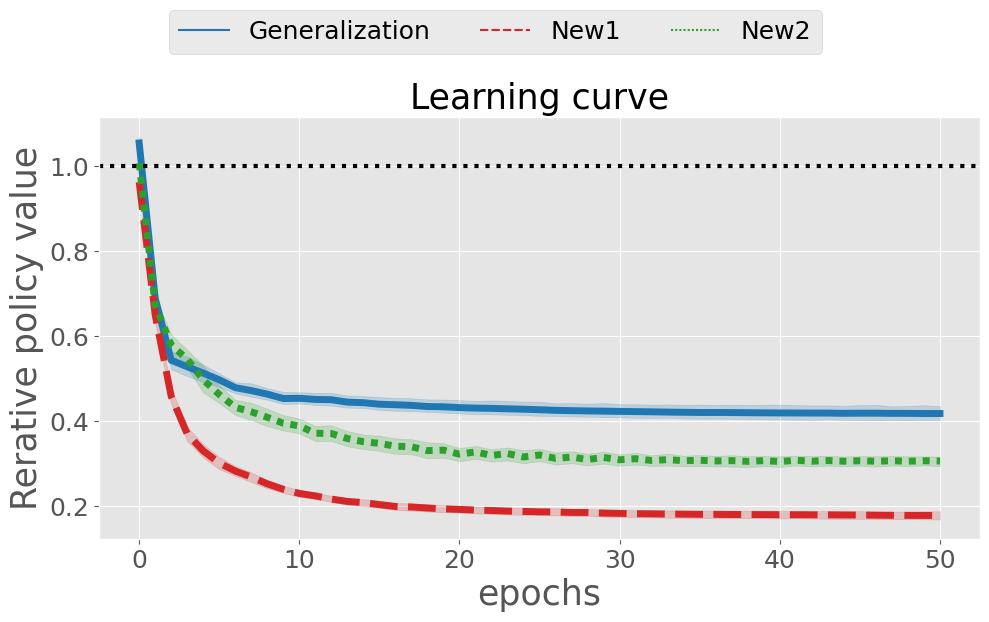

In [6]:
# curve of (x,a,r) variances. i.e., \mathbb{V}_{x,a,r \sim \pi_{\theta}}[r]
# New1 achieved the lowest variance. This indicates that is confidence policy.
# Generalization and New2 is unreliable estimation while their policy value is higher than than of New1.
visualize_learning_curve(new1_value_df)

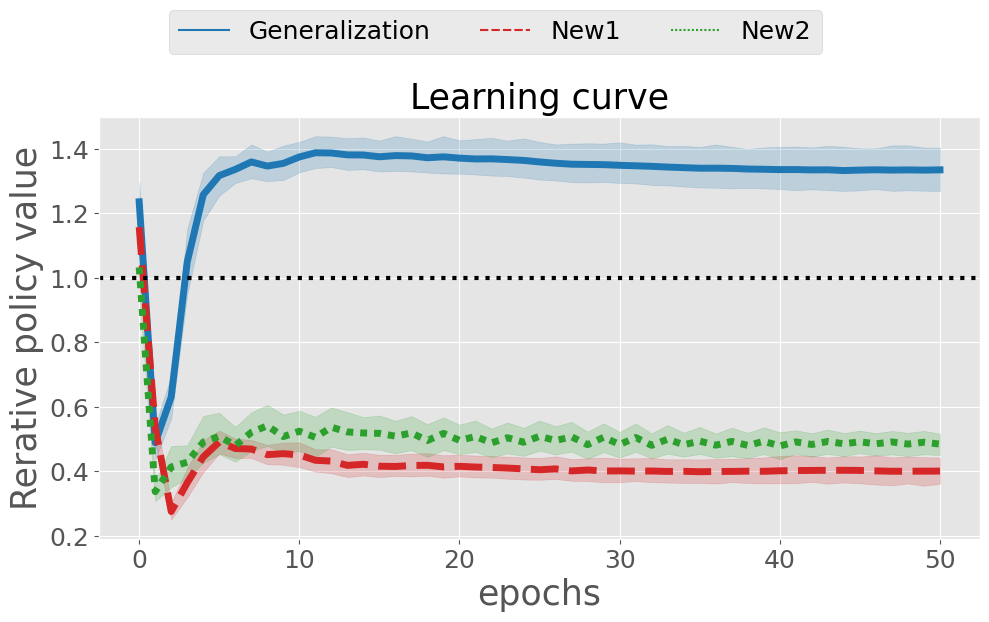

In [7]:
# curve of reward variance for each user. i.e., \mathbb{V}_{x}[\mathbb{E}_{a,r \sim \pi_{\theta}}[r]]
# New2 achieved the lowest reward variance for each user. So, the New2 policy enables us to fairly recommend items to each user,
# even when some users are not easily observable. In this context, the New1 policy exhibits bias.
visualize_learning_curve(new2_value_df)